In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb # ask bojan tunguz why you have to use it
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import brier_score_loss # competition metric
from sklearn.metrics import mean_absolute_error # win margin proxy model metric
from scipy.interpolate import UnivariateSpline # interpolate win margin model to probabilities

In [2]:
# read the necessary data
sample_submission = pd.read_csv('/kaggle/input/march-machine-learning-mania-2023/SampleSubmission2023.csv')

tourney_results = pd.concat(
    [pd.read_csv('/kaggle/input/march-machine-learning-mania-2023/MNCAATourneyDetailedResults.csv'), 
     pd.read_csv('/kaggle/input/march-machine-learning-mania-2023/WNCAATourneyDetailedResults.csv')]
)
seeds = pd.concat(
    [pd.read_csv('/kaggle/input/march-machine-learning-mania-2023/MNCAATourneySeeds.csv'), 
     pd.read_csv('/kaggle/input/march-machine-learning-mania-2023/WNCAATourneySeeds.csv')]
)
regular_results = pd.concat(
    [pd.read_csv('/kaggle/input/march-machine-learning-mania-2023/MRegularSeasonDetailedResults.csv'), 
     pd.read_csv('/kaggle/input/march-machine-learning-mania-2023/WRegularSeasonDetailedResults.csv')]
)
fivethirtyeight = pd.concat(
    [pd.read_csv('/kaggle/input/ncaa-men-538-team-ratings/538ratingsMen.csv'),
     pd.read_csv('/kaggle/input/ncaa-women-538-team-ratings/538ratingsWomen.csv')]
)

In [3]:
# double the dataset with swapped team positions in box scores (free lunch data)
def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]
    output = pd.concat([df, dfswap]).reset_index(drop=True)   
    return output

regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

In [4]:
# train models on the tourney results only
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data['men_women'] = tourney_data['T1_TeamID'].apply(lambda t: 0 if str(t)[0]=='1' else 1) # men: 0, women: 1
tourney_data['point_diff'] = tourney_data['T1_Score'] - tourney_data['T2_Score']

In [5]:
# append average box score statistics
boxscore_cols = ['T1_Score', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 
                 'T2_Score', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF']

season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(np.mean).reset_index()
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ['T1_avg_' + x.replace('T1_','').replace('T2_','opponent_') for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ['T2_avg_' + x.replace('T1_','').replace('T2_','opponent_') for x in list(season_statistics_T2.columns)]
season_statistics_T1 = season_statistics_T1.rename({'T1_avg_Season':'Season','T1_avg_TeamID':'T1_TeamID'},axis=1)
season_statistics_T2 = season_statistics_T2.rename({'T2_avg_Season':'Season','T2_avg_TeamID':'T2_TeamID'},axis=1)

tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

# append stdev box score statistics
season_statistics_std = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(np.std).reset_index()
season_statistics_T1_std = season_statistics_std.copy()
season_statistics_T2_std = season_statistics_std.copy()

season_statistics_T1_std.columns = ['T1_std_' + x.replace('T1_','').replace('T2_','opponent_') for x in list(season_statistics_T1_std.columns)]
season_statistics_T2_std.columns = ['T2_std_' + x.replace('T1_','').replace('T2_','opponent_') for x in list(season_statistics_T2_std.columns)]
season_statistics_T1_std = season_statistics_T1_std.rename({'T1_std_Season':'Season','T1_std_TeamID':'T1_TeamID'},axis=1)
season_statistics_T2_std = season_statistics_T2_std.rename({'T2_std_Season':'Season','T2_std_TeamID':'T2_TeamID'},axis=1)

tourney_data = pd.merge(tourney_data, season_statistics_T1_std, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2_std, on = ['Season', 'T2_TeamID'], how = 'left')

In [6]:
# append seed numbers
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [ ]:
# append 538 ratings
# fivethirtyeight.drop('TeamName', axis=1, inplace=True)
# fivethirtyeight_T1 = fivethirtyeight.copy()
# fivethirtyeight_T2 = fivethirtyeight.copy()
# fivethirtyeight_T1.columns = ['Season','T1_TeamID','T1_538rating']
# fivethirtyeight_T2.columns = ['Season','T2_TeamID','T2_538rating']

# tourney_data = pd.merge(tourney_data, fivethirtyeight_T1, on = ['Season', 'T1_TeamID'])
# tourney_data = pd.merge(tourney_data, fivethirtyeight_T2, on = ['Season', 'T2_TeamID'])

In [8]:
# remove the outlier (#16 won over #1)
tourney_data = tourney_data.loc[~((tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score<tourney_data.T2_Score))]
tourney_data = tourney_data.loc[~((tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score>tourney_data.T2_Score))]

In [9]:
# build proxy models to predict win margin
features = ['T1_538rating', 'T2_538rating',
            'T1_avg_Score', 'T2_avg_Score', 
            'T1_std_Score', 'T2_std_Score', 
            'T1_avg_opponent_FGA', 'T2_avg_opponent_FGA',
            'T1_avg_opponent_TO','T2_avg_opponent_TO',
            'T1_avg_PF','T2_avg_PF']

param = {} 
param['objective'] = 'reg:squarederror'
param['booster'] = 'gbtree'
param['eta'] = 0.01
param['subsample'] = 0.6
param['colsample_bynode'] = 1.0
param['num_parallel_tree'] = 2
param['min_child_weight'] = 32
param['max_depth'] = 6
num_rounds = 500

models = {}
oof_mae = []
oof_preds = []
oof_targets = []

# leave-one-season out models
for oof_season in set(tourney_data.Season):
    x_train = tourney_data.loc[tourney_data.Season!=oof_season, features].values
    y_train = tourney_data.loc[tourney_data.Season!=oof_season, 'point_diff'].values   
    x_val = tourney_data.loc[tourney_data.Season==oof_season, features].values
    y_val = tourney_data.loc[tourney_data.Season==oof_season, 'point_diff'].values
    
    y_train = np.clip(y_train,-12,12)
    y_val = np.clip(y_val,-12,12)    
       
    dtrain = xgb.DMatrix(x_train, label = y_train)
    dval = xgb.DMatrix(x_val, label = y_val)
    models[oof_season] = xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = num_rounds,
    )
    preds = models[oof_season].predict(dval)
    print(f'oof season {oof_season} mae: {mean_absolute_error(y_val, preds)}')
    oof_mae.append(mean_absolute_error(y_val, preds))
    oof_preds += list(preds)
    oof_targets += list(y_val)
    
print(f'average mae: {np.mean(oof_mae)}')

oof season 2016 mae: 5.598572742595122
oof season 2017 mae: 5.387713730134643
oof season 2018 mae: 5.787135573147341
oof season 2019 mae: 5.496850499568077
oof season 2021 mae: 6.353601410421867
oof season 2022 mae: 6.455767043935719
average mae: 5.846606833300462


In [10]:
# estimate spline model on predicted win margins
t = 12
dat = list(zip(oof_preds, np.array(oof_targets)>0))
dat = sorted(dat, key = lambda x: x[0]) # need to have this increasing for UnivariateSpline
pred, label = list(zip(*dat))
spline_model = UnivariateSpline(np.clip(pred, -t, t), label, k=3) # clip predicted win margin for better fit
spline_fit = np.clip(spline_model(np.clip(oof_preds, -t, t)), 0, 1)
print(f"brier: {brier_score_loss(np.array(oof_targets)>0, spline_fit)}") 
#brier: 0.1648473458364873

brier: 0.1648473458364873


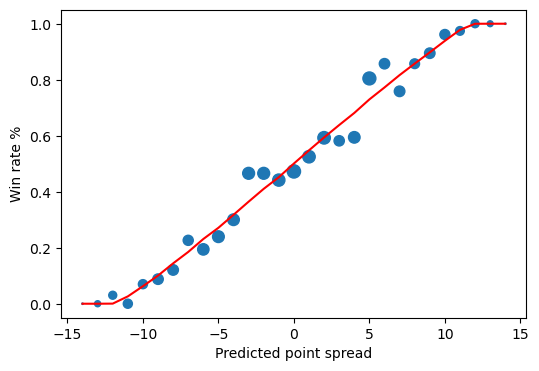

In [11]:
# win margin model predictions and win probability spline fit on the same plot
df = pd.DataFrame({'pred': np.round(oof_preds,0), 
                   'label': np.array(oof_targets)>0, 
                   'spline_fit': spline_fit})
df = df.groupby('pred')[['label', 'spline_fit']].agg(['mean', 'count']).reset_index()

fig, ax1 = plt.subplots(figsize = (6,4))
ax1.scatter(df['pred'], df['label']['mean'], df['label']['count'])
ax1.plot(df['pred'], df['spline_fit']['mean'], 'r')
ax1.set_xlabel('Predicted point spread')
ax1.set_ylabel('Win rate %')
plt.show()

In [12]:
# construct dataframe for submission
X = sample_submission.copy()
X['Season'] = X['ID'].apply(lambda t: int(t.split('_')[0]))
X['T1_TeamID'] = X['ID'].apply(lambda t: int(t.split('_')[1]))
X['T2_TeamID'] = X['ID'].apply(lambda t: int(t.split('_')[2]))
X['men_women'] = X['T1_TeamID'].apply(lambda t: 0 if str(t)[0]=='1' else 1)
X = pd.merge(X, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
X = pd.merge(X, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')
X = pd.merge(X, season_statistics_T1_std, on = ['Season', 'T1_TeamID'], how = 'left')
X = pd.merge(X, season_statistics_T2_std, on = ['Season', 'T2_TeamID'], how = 'left')
X = pd.merge(X, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
X = pd.merge(X, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
X = pd.merge(X, fivethirtyeight_T1, on = ['Season', 'T1_TeamID'], how = 'left')
X = pd.merge(X, fivethirtyeight_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [13]:
# inference for every model, take average as final prediction
preds = []
for oof_season in set(tourney_data.Season):
    dtest = xgb.DMatrix(X[features].values)
    margin_preds = models[oof_season].predict(dtest)
    probs = np.clip(spline_model(np.clip(margin_preds, -t, t)), 0, 1)
    preds.append(probs)
X['Pred'] = np.array(preds).mean(axis=0)    

<AxesSubplot:xlabel='Pred', ylabel='Count'>

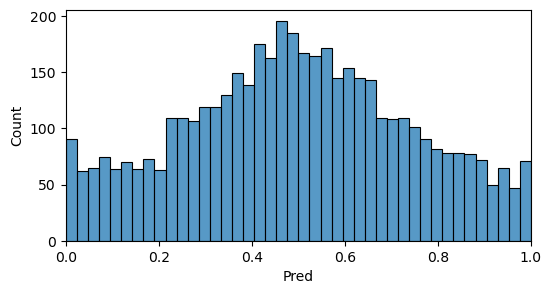

In [14]:
# sanity check to check for win probability distribution
m = X.loc[(~pd.isnull(X.T1_seed)) & (~pd.isnull(X.T2_seed))]
plt.figure(figsize=(6, 3))
plt.xlim(0, 1)
sns.histplot(m['Pred'], bins=42)

In [15]:
# make some "low-risk" overrides
X.loc[(X.men_women==0) & (X.T1_seed<=2) & (X.T2_seed>=15),'Pred'] = 1
X.loc[(X.men_women==0) & (X.T1_seed>=15) & (X.T2_seed<=2),'Pred'] = 0
X.loc[(X.men_women==1) & (X.T1_seed<=4) & (X.T2_seed>=13),'Pred'] = 1
X.loc[(X.men_women==1) & (X.T1_seed>=13) & (X.T2_seed<=4),'Pred'] = 0

In [16]:
# sanity check to check for seed matchup win probability distribution 
pd.pivot_table(data = X, index='T1_seed', columns='T2_seed', values='Pred', aggfunc='mean').style.bar(color='#5fba7d', vmin=0, vmax=1)

T2_seed,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0
T1_seed,,,,,,,,,,,,,,,,
1.0,0.497744,0.562077,0.678111,0.669855,0.744160,0.710313,0.723004,0.775341,0.750475,0.788692,0.812937,0.804965,0.882128,0.909172,1.000000,1.000000
2.0,0.390868,0.524633,0.600208,0.603251,0.676452,0.633500,0.646927,0.734723,0.742226,0.752879,0.797445,0.814387,0.893067,0.903797,1.000000,1.000000
3.0,0.326692,0.421183,0.548205,0.524714,0.591112,0.564208,0.578703,0.680446,0.670068,0.675321,0.723442,0.756383,0.858795,0.870177,0.885437,0.927297
4.0,0.342051,0.429035,0.623748,0.575506,0.619411,0.579948,0.594797,0.667289,0.658463,0.703980,0.673623,0.729481,0.783390,0.770198,0.854333,0.861554
5.0,0.245587,0.328694,0.483572,0.445341,0.561279,0.561455,0.568141,0.679960,0.658488,0.654581,0.727942,0.743675,0.824944,0.820057,0.797612,0.873407
6.0,0.242441,0.310884,0.431533,0.422351,0.513498,0.480752,0.537905,0.627952,0.631703,0.634548,0.686537,0.712740,0.818519,0.811138,0.798424,0.855465
7.0,0.185608,0.226142,0.333012,0.338691,0.405008,0.373102,0.444063,0.540191,0.539850,0.558153,0.608767,0.641494,0.775044,0.736339,0.711880,0.775283
8.0,0.203220,0.263039,0.438848,0.321399,0.434933,0.429115,0.480207,0.547587,0.510120,0.544384,0.597330,0.621607,0.720929,0.666105,0.670198,0.762968
9.0,0.170941,0.234026,0.360284,0.301480,0.379640,0.367429,0.434463,0.448247,0.484850,0.504226,0.541150,0.555174,0.663197,0.654160,0.622614,0.690975


In [17]:
X[['ID','Pred']].to_csv('submission-model-2.csv',index=None)